In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    InputLayer,
    BatchNormalization,
    Input,
    Dropout,
    RandomFlip,
    RandomRotation,
    RandomContrast,
    Rescaling,
    Resizing

)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
from google.colab import drive



In [2]:
! pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# go back to kaggle and copy the api command of the dataset
# paste

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:02<00:00, 165MB/s]
100% 309M/309M [00:02<00:00, 152MB/s]


In [6]:
# https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

# unzip and save in this folder

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [8]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"

val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAMES = ["angry", "happy", "sad"]



CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}


In [9]:
# how to view images from directory

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
   
)


# seed is given so that we always have the same shuffling

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)



Found 2278 files belonging to 3 classes.


In [11]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

**data visualization**

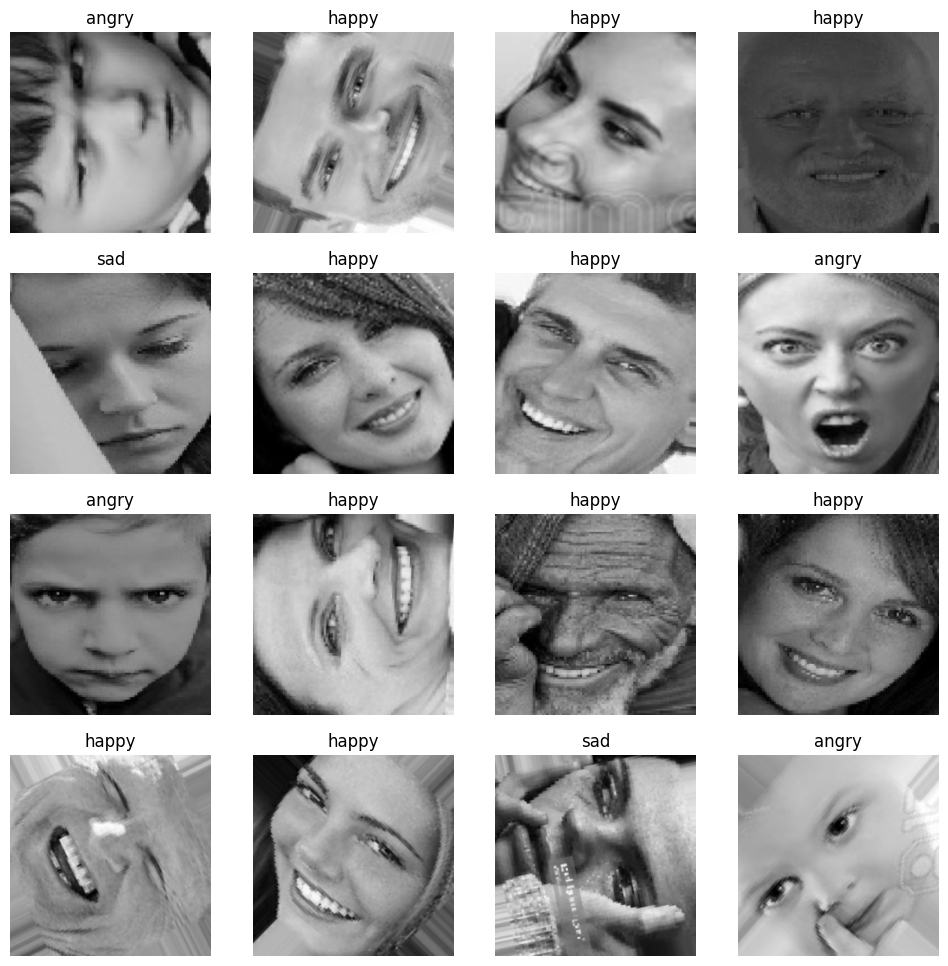

In [13]:
plt.figure(figsize = (12,12))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
    plt.axis("off")

**DATA PREPARATION**

In [22]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
val_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [24]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    tf.keras.layers.Rescaling(1.0 / 255)
])



**Modelling**

In [26]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    # Rescaling(1./255, name="rescaling"),

    resize_rescale_layers,

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="sigmoid"),
])

lenet_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

**Training**

In [27]:
loss_function = CategoricalCrossentropy()


In [28]:
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_k_accuracy")
]

In [29]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [30]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 29s 70ms/step - loss: 0.9886 - accuracy: 0.5382 - top_k_accuracy: 0.7981 - val_loss: 1.0179 - val_accuracy: 0.4934 - val_top_k_accuracy: 0.7788
Epoch 2/20
213/213 [==============================] - 14s 64ms/step - loss: 0.7036 - accuracy: 0.6983 - top_k_accuracy: 0.9007 - val_loss: 0.9069 - val_accuracy: 0.5799 - val_top_k_accuracy: 0.8406
Epoch 3/20
213/213 [==============================] - 14s 64ms/step - loss: 0.4740 - accuracy: 0.8182 - top_k_accuracy: 0.9550 - val_loss: 1.0937 - val_accuracy: 0.5075 - val_top_k_accuracy: 0.8481
Epoch 4/20
213/213 [==============================] - 19s 86ms/step - loss: 0.3174 - accuracy: 0.8881 - top_k_accuracy: 0.9748 - val_loss: 0.9051 - val_accuracy: 0.7046 - val_top_k_accuracy: 0.8924
Epoch 5/20
213/213 [==============================] - 14s 66ms/step - loss: 0.2032 - accuracy: 0.9320 - top_k_accuracy: 0.9890 - val_loss: 0.9157 - val_accuracy: 0.6910 - val_top_k_accuracy: 0.8832
Epoch 6/20

In [31]:
y_true = [[0, 1, 0], [0, 0, 1]]

y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]] 

cce= tf.keras.losses. CategoricalCrossentropy()
print(cce(y_true, y_pred). numpy())

1.1769392


In [32]:
y_true = [0, 1]

y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]] 

cce= tf.keras.losses.SparseCategoricalCrossentropy()
print(cce(y_true, y_pred). numpy())

1.609438


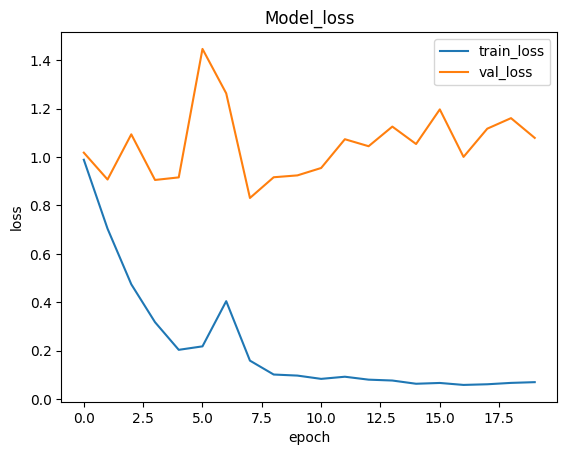

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

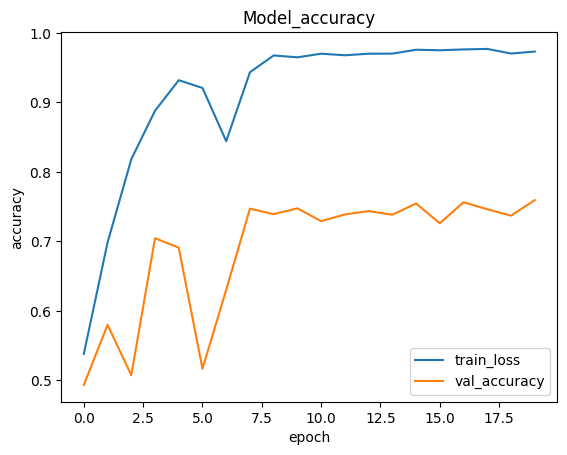

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_accuracy'])
plt.show()

**EVALUATION**

In [35]:
lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 35ms/step - loss: 1.0789 - accuracy: 0.7594 - top_k_accuracy: 0.9030


[1.0789258480072021, 0.7594380974769592, 0.9029850959777832]

**TESTING**

In [36]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_2.jpg")

im = tf.constant(test_image, dtype = tf.float32)
# add the batch dimension
im = tf.expand_dims(im, axis=0)
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis=-1).numpy()[0]])

happy


In [37]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_2.jpg")

im = tf.constant(test_image, dtype = tf.float32)
# add the batch dimension
im = tf.expand_dims(im, axis=0)
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis=-1).numpy()[0]])

happy


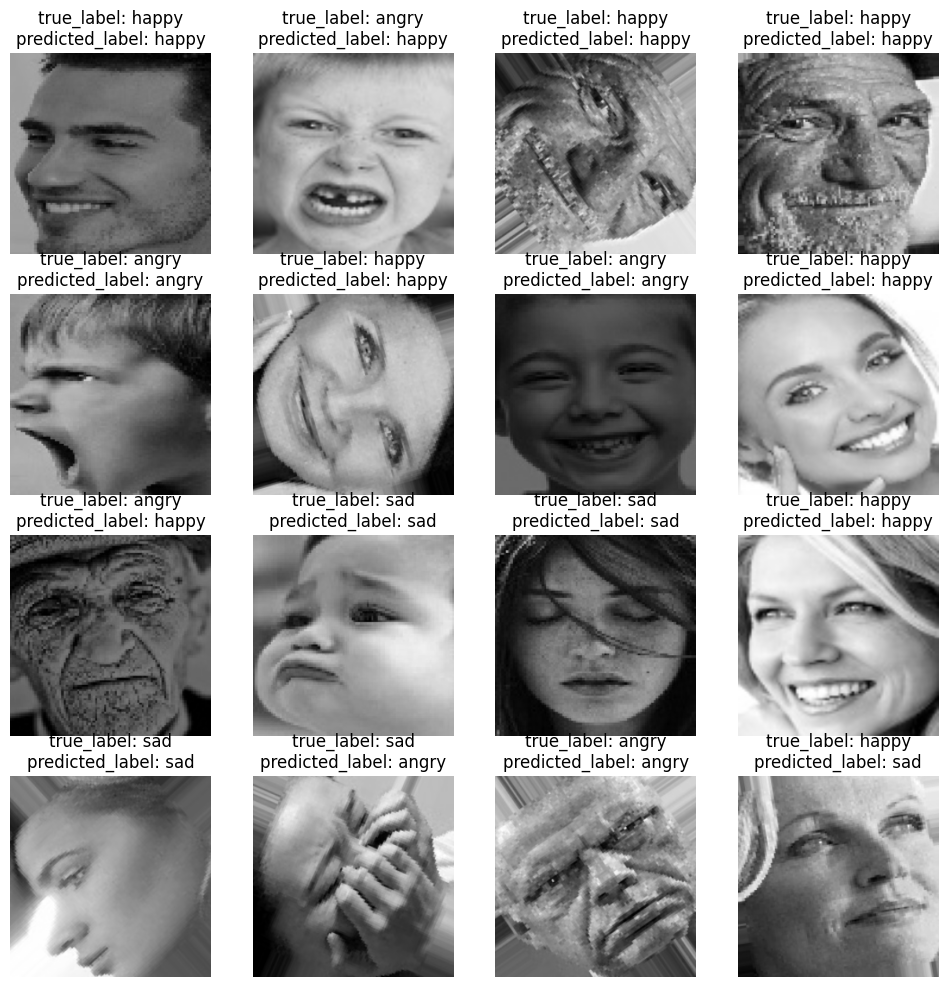

In [38]:
plt.figure(figsize=(12, 12))

for images, labels in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.0)
        true_label = CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()]
        predicted_label = CLASS_NAMES[tf.argmax(lenet_model(images[i][tf.newaxis], training=False), axis=-1).numpy()[0]]
        plt.title(f"true_label: {true_label}\npredicted_label: {predicted_label}")
        plt.axis("off")

plt.show()


**CONFUSION MATRIX**

In [39]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())


In [40]:
print(len(np.argmax(labels[:-1], axis= -1).flatten()))

print(len(np.argmax(predicted[:-1], axis= -1).flatten()))



2272
2272


In [41]:
pred = np.argmax(predicted[:-1], axis= -1).flatten()

lab = np.argmax(labels[:-1], axis= -1).flatten()

[[327 101  86]
 [ 51 834 119]
 [ 65 126 563]]


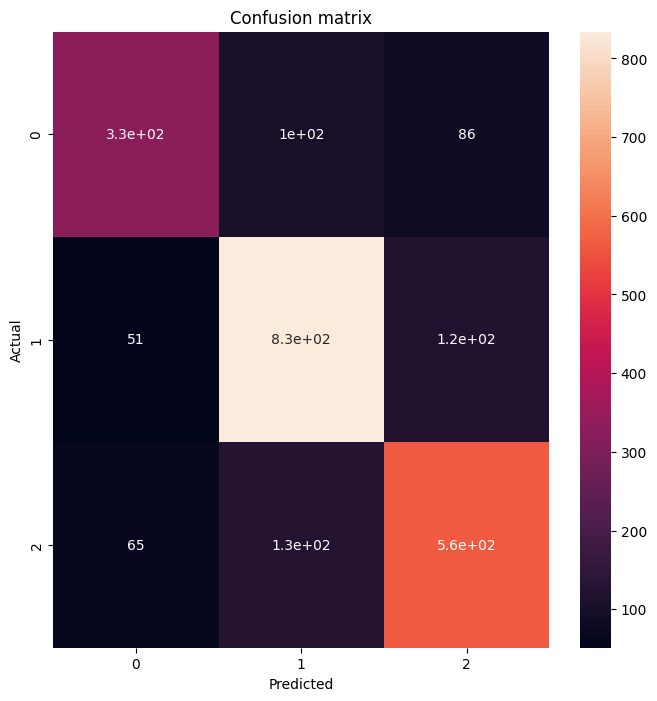

In [42]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,)

plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()
